# Deep Neural Network Steps

In this notebook I will build a deep neural network with custom number of hidden layers and a binary classification output layer!
- Activation function of hidden layers: ReLU
- Activation function of outpul layer: Sigmoid

In [1]:
import numpy as np
from dnn_utils_v1 import sigmoid, sigmoid_backward, relu, relu_backward

np.random.seed(2021)


## Roadmap

To build a deep neural network, I'll be implementing several helper functions. These functions will be used in the next notebook to build and test a deep neural network. 

Here is a roadmap (inspired by deeplearning.ai) of what I will be doing to define the functions:

- Initialize the parameters for an $L$-layer neural network
- Implement the forward propagation functions
     - Complete the LINEAR part of a layer's forward propagation step (resulting in $Z$).
     - I will be using the relu and sigmoid activation functions loaded from `dnn_utils_v1.py`
     - Combine the previous two steps into a new [LINEAR->ACTIVATION] forward function.
     - Stack the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer $L$). This gives a new L_model_forward function.
- Compute the loss
- Implement the backward propagation module
    - Complete the LINEAR part of a layer's backward propagation step
    - I will be using the relu_backward and sigmoid_backward as the gradients of the activation functions loaded from `dnn_utils_v1.py` 
    - Combine the previous two steps into a new [LINEAR->ACTIVATION] backward function
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally, update the parameters

**Caches**

For every forward function, there is a corresponding backward function. For this, we will be storing some values in a cache at every step of your forward module. The cached values will later be used to compute gradients in the backpropagation module. 

See this diagram for more details:
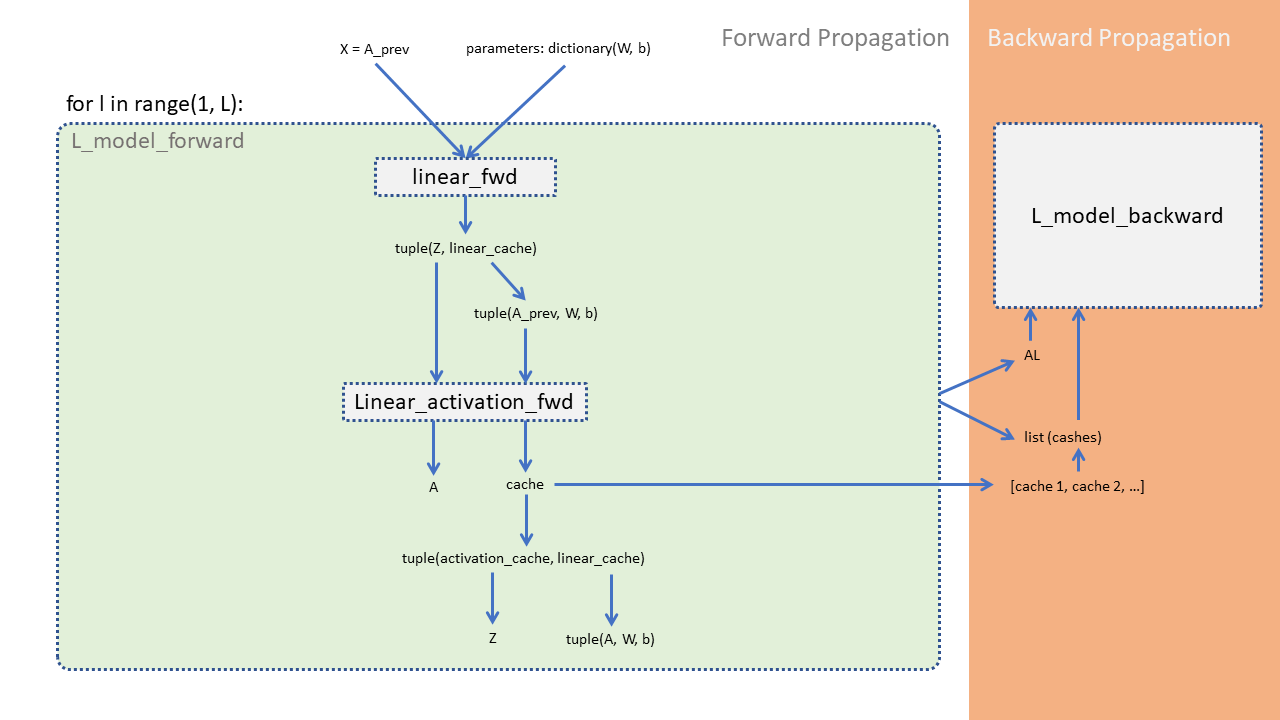

## 1 - Initialization

We will write a helper function to initialize the parameters for the model.


The initialization for a deeper L-layer neural network is more complicated than a two layer because there are many more weight matrices and bias vectors, and we need to make sure that the dimensions match between each layer.

- We use random initialization for the weight matrices and zeros initialization for the biases.
- Number of units in different layers, is stored in a list called `layer_dims`. e.g. [40, 4, 3, 1]
- We will iterate through all layer_dims to intiate W and b parameters for each layer. The general case of each layer is as follows:
> $ W^{[l]}$ will be of shape `(layer_dims[l], layer_dims[l-1])`  
> $ b^{[l]}$ will be of shape `(layer_dims[l], 1)`


In [2]:
def initialize_parameters_deep(layer_dims):
    """
    Parameters
    ----------
    layer_dims : list
        containing the dimensions of each layer

    Returns
    -------
    parameters : dictionary
        containing weight matrix W, bias vector b for each layer
    """

    np.random.seed(2021)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters["W" + str(l)] = (
            np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        )
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

## 2 - Forward Propagation

### 2.1 - Linear Forward 

The vectorized version of linear forward module computes:

$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$ where $A^{[0]} = X$. 


In [3]:
def linear_fwd(A_prev, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Parameters
    ----------
    A_prev : array
        activations from previous layer
    W : array
        weights matrix
    b : array
        bias vector

    Returns:
    Z : array
        pre-activation parameter
    cache : tuple
        containing "A", "W" and "b"
    """

    Z = np.dot(W, A_prev) + b
    linear_cache = (A_prev, W, b)

    return Z, linear_cache

### 2.2 - Linear-Activation Forward



We are implementing the forward propagation of the *LINEAR->ACTIVATION* layer. Mathematical relation is: $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation "g" can be sigmoid() or relu(). We use `linear_fwd()` and the correct activation function imported from `dnn_utils_v1.py`.

In [4]:
def linear_activation_fwd(A_prev, W, b, activation):
    """
    Compute forward propagation for the LINEAR->ACTIVATION layer

    Parameters
    ----------
    A_prev : array
        activations from previous layer
    W : array
        weights matrix
    b : array
        bias vector
    activation : str
        the activation to be used in this layer("sigmoid" or "relu")

    Returns
    -------
    A : array
        the post-activation value
    cache : tuple
        containing "linear_cache" and "activation_cache"
    """

    if activation == "sigmoid":
        Z, linear_cache = linear_fwd(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        Z, linear_cache = linear_fwd(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache

### 2.3 - L-Layer Model 

We will write a function that replicates the previous one (`linear_activation_fwd` with RELU) $L-1$ times, then follows that with one `linear_activation_fwd` with SIGMOID.

In the code below, the variable `AL` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. This is $\hat{Y}$ after each iteration.


In [5]:
def L_model_forward(X, parameters):
    """
    Implement forward propagation computation

    Parameters
    ----------
    X : array
        input data of shape (input size, number of examples)
    parameters : dict
        output of initialize_parameters_deep()

    Returns
    -------
    AL : array
        activation value from the output (last) layer
    caches : list
        containing every cache of linear_activation_fwd()
    """

    caches = []
    A = X
    L = len(parameters) // 2  # number of layers, 2 parameters per layer

    # Implement [LINEAR -> RELU]*(L-1)
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_fwd(
            A_prev,
            parameters["W" + str(l)],
            parameters["b" + str(l)],
            activation="relu",
        )
        caches.append(cache)

    # Implement LINEAR -> SIGMOID
    AL, cache = linear_activation_fwd(
        A, parameters["W" + str(L)], parameters["b" + str(L)], activation="sigmoid"
    )
    caches.append(cache)

    return AL, caches

## 3 - Cost Function

We will compute the cost, in order to check whether your model is actually learning using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right))$$


In [6]:
def compute_cost(AL, Y):
    """
    Implement the cost function.

    Parameters
    ----------
    AL : array
        probability vector corresponding to label predictions
    Y : array
        true label vector with same shape as AL

    Returns
    -------
    cost : float
        cross-entropy cost
    """
    m = Y.shape[1]

    cost = -1 / m * (np.dot(np.log(AL), Y.T) + np.dot((1 - Y), np.log(1 - AL).T))
    cost = np.squeeze(cost)  # To turn array to float

    return cost

## 4 - Backward Propagation Module

Just like for the forward propagation, we will implement helper functions for backpropagation. We build the backward propagation in three steps:
1. LINEAR backward
2. LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
3. [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)
 
In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, we use the chain rule and do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During backpropagation, at each step we multiply our current gradient by the gradient corresponding to the specific layer to get the gradient we want.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, we use the previous chain rule and do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.


### 4.1 - Linear Backward

Assuming that we have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$ we want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ in this step.


The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.

Here are the formulas:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]}$$


In [7]:
def linear_backward(dZ, linear_cache):
    """
    linear portion of backward propagation for a single layer

    Parameters
    ----------
    dZ : array
        Gradient of the cost with respect to the linear output (of current layer l)
    cache : tuple
        values (A_prev, W, b) coming from the forward propagation

    Returns
    -------
    dA_prev : array
        Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW : array
        Gradient of the cost with respect to W (current layer l), same shape as W
    db : array
        Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]

    dW = 1 / m * np.dot(dZ, A_prev.T)
    db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


### 4.2 - Linear-Activation Backward

Now we use two helper functions `sigmoid_backward()` and `relu_backward()` from `dnn_utils_v1.py` to tell the model which backward gradient we want it to calculate. 

In [8]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.

    Parameters
    ----------
    dA : array
        post-activation gradient for current layer l
    cache : tuple
        of values (linear_cache, activation_cache) we stored during forward propagation
    activation : str
        the activation to be used in this layer("sigmoid" or "relu")

    Returns
    -------
    dA_prev : array
        Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW : array
        Gradient of the cost with respect to W (current layer l), same shape as W
    db : array
        Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


### 4.3 - L-Model Backward 

When we implemented the `L_model_forward` function, at each iteration, we stored a cache which contains (A,W,b, and z). In the back propagation module, we'll use these variables to compute the gradients. Therefore, in the `L_model_backward` function, we'll iterate through all the hidden layers backward, starting from layer $L$. On each step, we will use the cached values for layer $l$ to backpropagate through layer $l$.

**Initializing backpropagation**:

To backpropagate through this network, we know that the output is: 
$A^{[L]} = \sigma(Z^{[L]})$ . Your code thus needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, use this formula (inspired from deeplearning.ai):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

You can then use this post-activation gradient `dAL` to keep going backward by feeding in `dAL` into the LINEAR->SIGMOID backward function. 

After that, we will have to use a for loop to iterate through all the other layers using the LINEAR->RELU backward function. We need to store each dA, dW, and db in the grads dictionary. 

In [9]:
def L_model_backward(AL, Y, caches):
    """
    backward propagation for [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID

    Parameters
    ----------
    AL : array
        probability vector from each forward propagation
    Y : array
        true label vector
    caches : list
        of caches containing every cache of linear_activation_fwd() with "relu"
        and the cache of linear_activation_fwd() with "sigmoid"

    Returns
    -------
    grads : dictionary
        of gradients dA, db and dW for each layer
    """
    grads = {}
    L = len(caches)  # number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)  # To make Y the same shape as AL

    # Initializing the backpropagation
    dAL = -(
        np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)
    )  # derivative of cost with respect to AL

    # Last layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L - 1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
        dA=dAL, cache=current_cache, activation="sigmoid"
    )
    grads["dA" + str(L - 1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp

    # Loop from l=L-2 to l=0
    for l in reversed(range(L - 1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
            dA=grads["dA" + str(l + 1)], cache=current_cache, activation="relu"
        )
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### 4.4 - Update Parameters

Finally, we will update the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} $$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} $$

where $\alpha$ is the learning rate. 

In [10]:
def update_parameters(params, grads, alpha):
    """
    Update parameters using gradient descent
    
    Parameters
    ----------
    params : dictionary 
        containing parameters W and b
    grads : dictionary 
        containing gradients
    alpha : float
        learning rate
    
    Returns
    -------
    parameters : dictionary 
        containing your updated parameters W and b
    """
    parameters = params.copy()
    L = len(parameters) // 2  # 2 parameters per layer

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - alpha * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - alpha * grads["db" + str(l+1)]

    return parameters